EDA

---

Imports


In [149]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import re

from sklearn.feature_extraction.text import CountVectorizer

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 400


---

Load Data


In [150]:
file_path = "../data/cleaned_data/reddit_data.csv"
df = pd.read_csv(file_path)
df.head(1)


,selftext,title,score,domain,id,author,num_comments,url,created_utc,subreddit,selftext_length,title_length,title_word_count,selftext_word_count,selftext_emoji_count,title_emoji_count
0,"If I wanted to play a virtual board game remotely with someone who didn't have a great PC but could still Zoom/Skype, what would you recommend? Any direction you can provide would be massively appreciated.&amp;#x200B;Here's the scenario I'd like to discover a solution for:* A roleplay game I can essentially DM on one side - She says ""Let's move here"" and I can adjust the tokens on both turns. ...",Virtual board games you can host over Zoom?,1,self.boardgames,105yauz,TylerDeLarm,0,https://www.reddit.com/r/boardgames/comments/105yauz/virtual_board_games_you_can_host_over_zoom/,1673122098,boardgames,640,43,8,112,0,0


In [106]:
df.shape


(11673, 16)

In [151]:
df = df.fillna("")


---

- Separate df by `subreddit`


In [152]:
bg_df = df[df["subreddit"] == "boardgames"]
wsb_df = df[df["subreddit"] == "wsb"]


---

- Check distribution of post lengths


In [153]:
def plot_word_count_dist(df, title, target_list, label_list):
    plt.figure(figsize=(15, 5))
    sns.set(style="darkgrid")
    sns.histplot(x=df[target_list[0]], color="skyblue", label=label_list[0], binwidth=3)
    sns.histplot(x=df[target_list[1]], color="red", label=label_list[1], binwidth=3)
    plt.legend()
    plt.title(title)
    plt.show()


Text(0.5, 0.98, 'SelfText Character & Word Count Distributions')

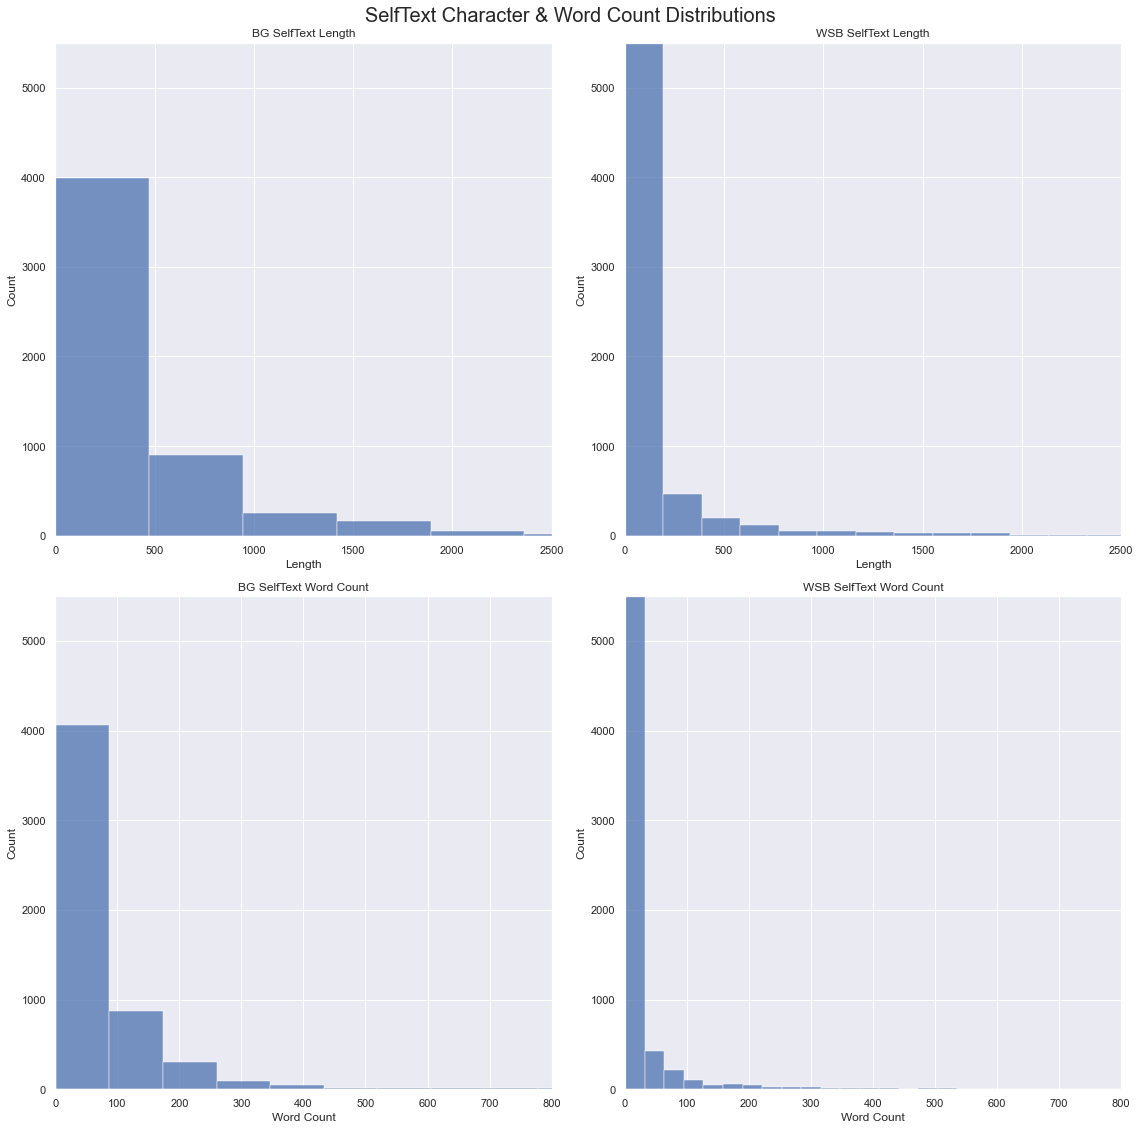

In [154]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16))
sns.set(style="darkgrid")
sns.histplot(bg_df["selftext_length"], ax=ax[0, 0], bins=83)
sns.histplot(wsb_df["selftext_length"], ax=ax[0, 1], bins=83)
sns.histplot(bg_df["selftext_word_count"], ax=ax[1, 0], bins=83)
sns.histplot(wsb_df["selftext_word_count"], ax=ax[1, 1], bins=83)

ax[0, 0].set(
    xlabel="Length", title="BG SelfText Length", xlim=[0, 2_500], ylim=[0, 5500]
)
ax[0, 1].set(
    xlabel="Length", title="WSB SelfText Length", xlim=[0, 2_500], ylim=[0, 5500]
)
ax[1, 0].set(
    xlabel="Word Count", title="BG SelfText Word Count", xlim=[0, 800], ylim=[0, 5500]
)
ax[1, 1].set(
    xlabel="Word Count", title="WSB SelfText Word Count", xlim=[0, 800], ylim=[0, 5500]
)

fig.set_tight_layout(True)
fig.suptitle("SelfText Character & Word Count Distributions", fontsize=20)


Text(0.5, 0.98, 'Title Character & Word Count Distributions')

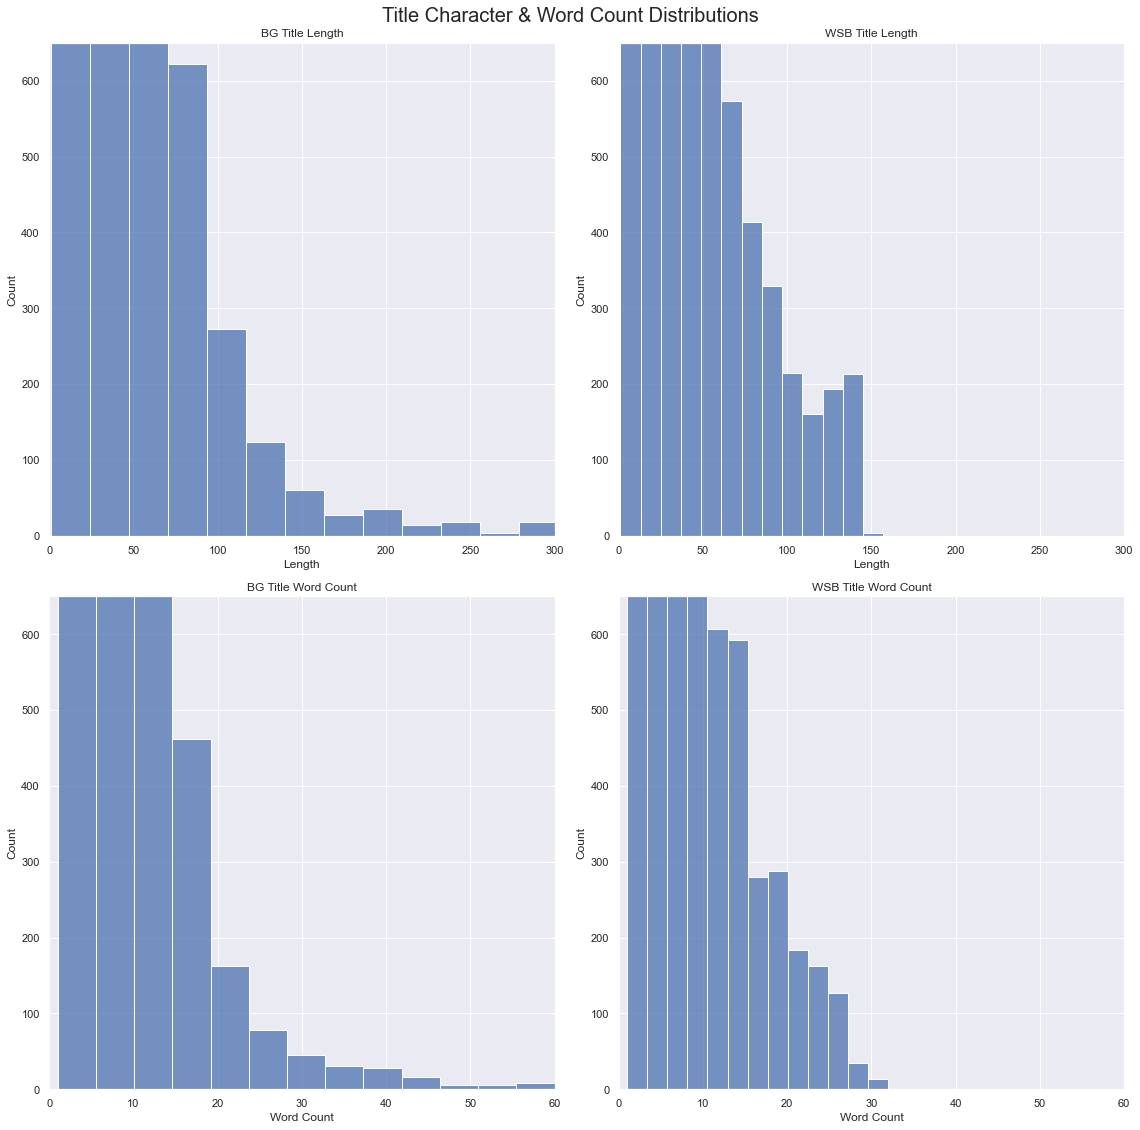

In [155]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16))
sns.set(style="darkgrid")
sns.histplot(bg_df["title_length"], ax=ax[0, 0], bins=13)
sns.histplot(wsb_df["title_length"], ax=ax[0, 1], bins=13)
sns.histplot(bg_df["title_word_count"], ax=ax[1, 0], bins=13)
sns.histplot(wsb_df["title_word_count"], ax=ax[1, 1], bins=13)

ax[0, 0].set(xlabel="Length", title="BG Title Length", xlim=[0, 300], ylim=[0, 650])
ax[0, 1].set(xlabel="Length", title="WSB Title Length", xlim=[0, 300], ylim=[0, 650])
ax[1, 0].set(
    xlabel="Word Count", title="BG Title Word Count", xlim=[0, 60], ylim=[0, 650]
)
ax[1, 1].set(
    xlabel="Word Count", title="WSB Title Word Count", xlim=[0, 60], ylim=[0, 650]
)

fig.set_tight_layout(True)
fig.suptitle("Title Character & Word Count Distributions", fontsize=20)


---

- Text Length and Word Count Summary Statistics


In [156]:
# Length and word count stats
length_word_count = [
    "selftext_length",
    "title_length",
    "selftext_word_count",
    "title_word_count",
]
bg_df[length_word_count].describe()


,selftext_length,title_length,selftext_word_count,title_word_count
count,5523.000000,5523.000000,5523.000000,5523.000000
mean,554.366467,53.700344,95.017020,9.438892
std,1863.356500,37.425650,318.516544,6.935650
min,0.000000,1.000000,1.000000,1.000000
25%,9.000000,30.000000,1.000000,5.000000
50%,220.000000,44.000000,39.000000,8.000000
75%,514.000000,67.000000,92.000000,12.000000
max,39223.000000,302.000000,7164.000000,60.000000


In [157]:
wsb_df[length_word_count].describe()


,selftext_length,title_length,selftext_word_count,title_word_count
count,7372.000000,7372.000000,7372.000000,7372.000000
mean,181.599566,47.658437,29.070673,8.769126
std,811.655679,33.796915,125.024210,6.213965
min,0.000000,1.000000,1.000000,1.000000
25%,0.000000,22.000000,1.000000,4.000000
50%,0.000000,38.000000,1.000000,7.000000
75%,9.000000,66.000000,1.000000,12.000000
max,16105.000000,157.000000,2611.000000,32.000000


> It looks like word `wsb` subreddit uses less words in `selftext` and `title` compare to `boardgames` subreddit based on summary statistics, distribution graph visually confirms it


---

- Combine `selftext` and `title` to `subreddit_text` and store `len` and `count`


In [158]:
df["subreddit_text"] = df["selftext"] + " " + df["title"]


In [159]:
df["subreddit_text_length"] = df["subreddit_text"].apply(len)


In [160]:
df["subreddit_text_word_count"] = df["subreddit_text"].apply(
    lambda text: len(text.split())
)


In [161]:
df[["subreddit_text_length", "subreddit_text_word_count"]].describe()


,subreddit_text_length,subreddit_text_word_count
count,12895.000000,12895.000000
mean,392.503916,65.442807
std,1380.319414,229.312219
min,2.000000,1.000000
25%,39.000000,7.000000
50%,87.000000,15.000000
75%,335.000000,57.000000
max,39244.000000,7107.000000


---

- Combine `emoji count` for `selftext` and `title`


In [162]:
df["subreddit_text_emoji_count"] = df["selftext_emoji_count"] + df["title_emoji_count"]


In [163]:
df["subreddit_text_emoji_count"].describe()


count    12895.000000
mean         0.213028
std          2.919394
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        153.000000
Name: subreddit_text_emoji_count, dtype: float64

---

- Re-assign `bg` and `wsb` dfs


In [164]:
bg_df = df[df["subreddit"] == "boardgames"]
wsb_df = df[df["subreddit"] == "wsb"]


---

- Top 15 `subreddit_text` - `CountVectorizer`


In [165]:
def custom_preprocessor(text):
    text = text.lower()
    text = re.sub("\\n", "", text)
    text = re.sub("(x200b)|(https?)|(')|(amp)|(com)|(png)|\d{4}", "", text)

    text = re.findall("[\w']+|\$[\d\.]+|", text)
    # Multi space to single space
    return " ".join(text)


ngram_global = (1, 1)
analyzer = CountVectorizer(
    stop_words=stopwords.words("english"),
    preprocessor=custom_preprocessor,
    ngram_range=ngram_global,
).build_analyzer()


def stemmed_words(text):
    p_stemmer = PorterStemmer()
    return (p_stemmer.stem(w) for w in analyzer(text))


def get_count_vec_stem(df, target, stemmer=False, ngram=(1, 1)):
    cv = CountVectorizer(
        stop_words=stopwords.words("english"),
        analyzer=stemmed_words if stemmer else "word",
        preprocessor=custom_preprocessor,
        ngram_range=ngram,
    )
    df_vect = cv.fit_transform(df["subreddit_text"])
    df_vect_df = pd.DataFrame(df_vect.todense(), columns=cv.get_feature_names_out())

    # Take a look at the top 15 words
    return df_vect_df.sum().sort_values(ascending=False)


C:\Users\btoli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['arent', 'couldnt', 'didnt', 'doesnt', 'dont', 'hadnt', 'hasnt', 'havent', 'isnt', 'mightnt', 'mustnt', 'neednt', 'shant', 'shes', 'shouldnt', 'shouldve', 'thatll', 'wasnt', 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youre', 'youve'] not in stop_words.
  warnings.warn(


<AxesSubplot: >

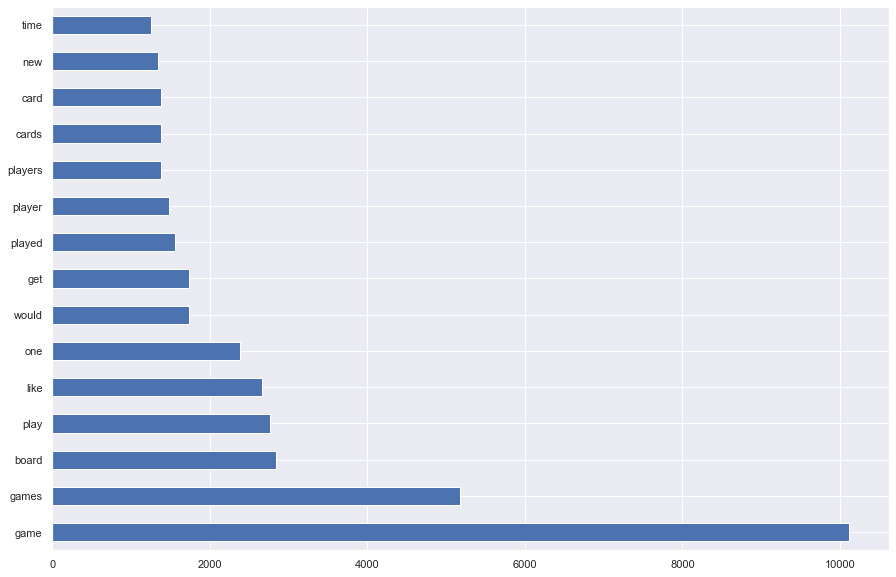

In [166]:
plt.figure(figsize=(15, 10))
get_count_vec_stem(bg_df, "subreddit_text").head(15).plot(kind="barh")


C:\Users\btoli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['arent', 'couldnt', 'didnt', 'doesnt', 'dont', 'hadnt', 'hasnt', 'havent', 'isnt', 'mightnt', 'mustnt', 'neednt', 'shant', 'shes', 'shouldnt', 'shouldve', 'thatll', 'wasnt', 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youre', 'youve'] not in stop_words.
  warnings.warn(


<AxesSubplot: >

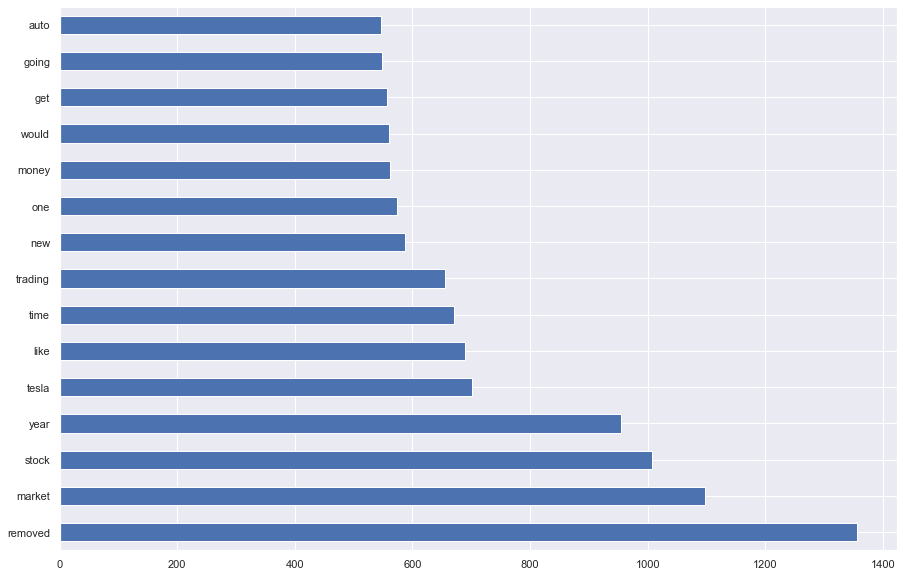

In [167]:
plt.figure(figsize=(15, 10))
get_count_vec_stem(wsb_df, "subreddit_text").head(15).plot(kind="barh")


---

- Top 15 `subreddit_text` - `CountVectorizer` with `stemmer`


C:\Users\btoli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\feature_extraction\text.py:534: UserWarning: The parameter 'preprocessor' will not be used since 'analyzer' is callable'
  warnings.warn(
C:\Users\btoli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\feature_extraction\text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


<AxesSubplot: >

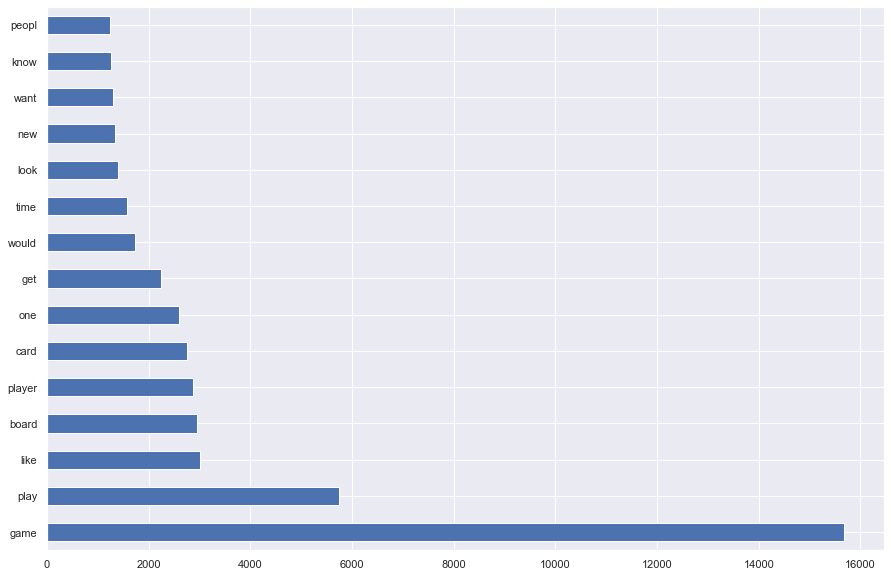

In [168]:
plt.figure(figsize=(15, 10))
get_count_vec_stem(bg_df, "subreddit_text", stemmer=True).head(15).plot(kind="barh")


C:\Users\btoli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\feature_extraction\text.py:534: UserWarning: The parameter 'preprocessor' will not be used since 'analyzer' is callable'
  warnings.warn(
C:\Users\btoli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\feature_extraction\text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


<AxesSubplot: >

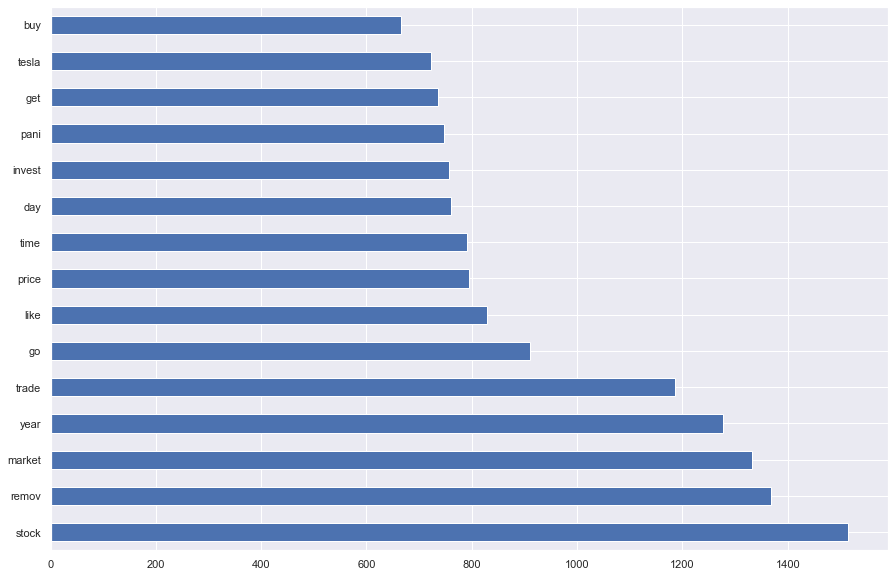

In [169]:
plt.figure(figsize=(15, 10))
get_count_vec_stem(wsb_df, "subreddit_text", stemmer=True).head(15).plot(kind="barh")


---

- Emoji Count Distribution


In [170]:
bg_df[["subreddit_text_emoji_count"]].describe()


,subreddit_text_emoji_count
count,5523.000000
mean,0.223067
std,4.021519
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,153.000000


In [171]:
wsb_df[["subreddit_text_emoji_count"]].describe()


,subreddit_text_emoji_count
count,7372.000000
mean,0.205507
std,1.671245
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,128.000000


> `boardgames` subreddit tend to have more emojis compare to `wsb`


---

- Cleanup df `subreddit_text`


In [172]:
df["subreddit_text"] = df["subreddit_text"].apply(custom_preprocessor)


---

- Output the data


In [173]:
df.to_csv("../data/after_eda/reddit_data.csv", index=False)
